
**Main imports**


In [0]:
%%capture
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'
!pip install -q torch torchvision livelossplot

import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from livelossplot import PlotLosses

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

**Import CIFAR-10 and filter out birds and horses into training sets**


In [2]:
# helper function to make getting another batch of data easier
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

class_names = ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

train_set = torchvision.datasets.CIFAR10('data', train=True, download=True, transform=torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor()]))

bird_ids = []
horse_ids = []
for i in range(0, len(train_set)):
    if train_set[i][1] == 2:
        bird_ids.append(i)
    elif train_set[i][1] == 7:
        horse_ids.append(i)

train_set_bird = torch.utils.data.Subset(train_set, bird_ids)
train_loader_bird = torch.utils.data.DataLoader(train_set_bird, batch_size=64)
train_iterator_bird = iter(cycle(train_loader_bird))

train_set_horse = torch.utils.data.Subset(train_set, horse_ids)
train_loader_horse = torch.utils.data.DataLoader(train_set_horse, batch_size=64)
train_iterator_horse = iter(cycle(train_loader_horse))

print(f'> Size of training dataset {len(train_loader_bird.dataset)}')
print(f'> Size of training dataset {len(train_loader_horse.dataset)}')

Files already downloaded and verified
> Size of training dataset 5000
> Size of training dataset 5000


**SN-GAN generator and discriminator models**

In [3]:
# define the model
class Generator(nn.Module):
    def __init__(self, f=64):
        super(Generator, self).__init__()
        self.generate = nn.Sequential(
            nn.ConvTranspose2d(100, f*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64*8),
            nn.ReLU(True),
            nn.ConvTranspose2d(f*8, f*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(f*4),
            nn.ReLU(True),
            nn.ConvTranspose2d(f*4, f*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(f*2),
            nn.ReLU(True),
            nn.ConvTranspose2d(f*2, f, 4, 2, 1, bias=False),
            nn.BatchNorm2d(f),
            nn.ReLU(True),
            nn.ConvTranspose2d(f, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

class Discriminator(nn.Module):
    def __init__(self, f=64):
        super(Discriminator, self).__init__()
        self.discriminate = nn.Sequential(
            torch.nn.utils.spectral_norm(nn.Conv2d(3, f, 3, 1, 1)),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(kernel_size=(2,2)),
            torch.nn.utils.spectral_norm(nn.Conv2d(f, f*2, 3, 1, 1)),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(kernel_size=(2,2)),
            torch.nn.utils.spectral_norm(nn.Conv2d(f*2, f*4, 3, 1, 1)),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(kernel_size=(2,2)),
            torch.nn.utils.spectral_norm(nn.Conv2d(f*4, f*8, 3, 1, 1)),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(kernel_size=(2,2)),
            nn.Dropout(0.2),
            torch.nn.utils.spectral_norm(nn.Conv2d(f*8, 3, 3, 1, 1)),
            nn.Sigmoid()
        )
        
G = Generator().to(device)
Dh = Discriminator().to(device)
Db = Discriminator().to(device)
print(f'> Number of generator parameters {len(torch.nn.utils.parameters_to_vector(G.parameters()))}')
print(f'> Number of discriminator parameters {len(torch.nn.utils.parameters_to_vector(Dh.parameters()))}')
print(f'> Number of discriminator parameters {len(torch.nn.utils.parameters_to_vector(Db.parameters()))}')

# initialise the optimiser
optimiser_G = torch.optim.Adam(G.parameters(), lr=0.001)
optimiser_Dh = torch.optim.Adam(Dh.parameters(), lr=0.001)
optimiser_Db = torch.optim.Adam(Db.parameters(), lr=0.001)

bce_loss = nn.BCELoss()
epoch = 0
liveplot = PlotLosses()

> Number of generator parameters 3576704
> Number of discriminator parameters 1564803
> Number of discriminator parameters 1564803


**Main training loop**

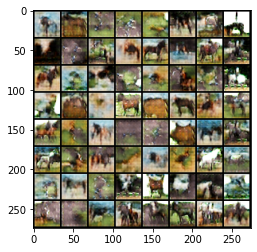

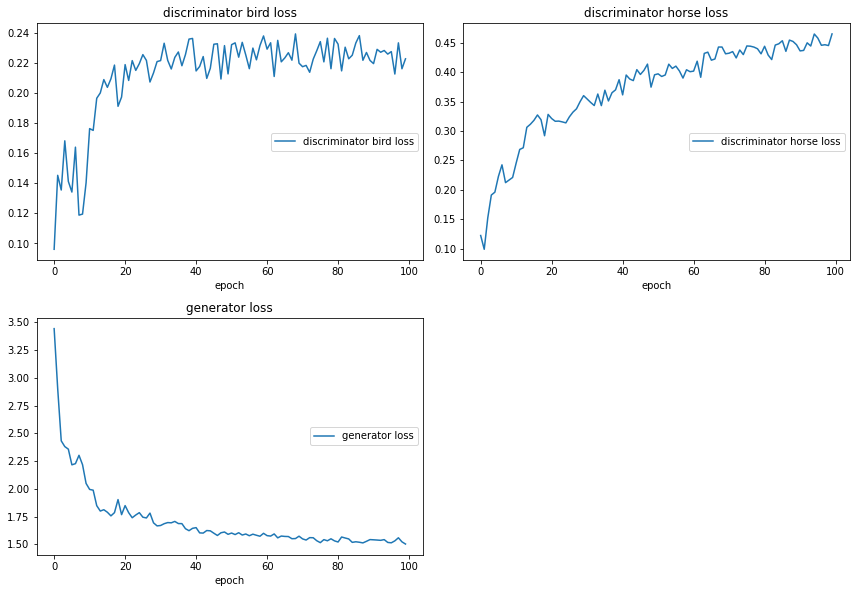

discriminator bird loss
	discriminator bird loss 	 (min:    0.096, max:    0.239, cur:    0.223)
discriminator horse loss
	discriminator horse loss 	 (min:    0.099, max:    0.465, cur:    0.465)
generator loss
	generator loss   	 (min:    1.502, max:    3.443, cur:    1.502)


In [4]:
# training loop
while (epoch<100):
    
    # arrays for metrics
    logs = {}
    gen_loss_arr = np.zeros(0)
    dish_loss_arr = np.zeros(0)
    disb_loss_arr = np.zeros(0)

    # iterate over some of the train dataset
    for i in range(100):

        # train discriminator horse
        for j in range(5): # /new
            x,t = next(train_iterator_horse)
            x,t = x.to(device), t.to(device)
            optimiser_Dh.zero_grad()
            g = G.generate(torch.randn(x.size(0), 100, 1, 1).to(device))
            #smooth labelling
            ones = torch.ones(1)[0] + np.random.uniform(-0.1, 0.1)
            zeros = torch.zeros(1)[0] 
            l_r = bce_loss(Dh.discriminate(x).mean(), ones.to(device)) # real -> 1
            l_f = bce_loss(Dh.discriminate(g.detach()).mean(), zeros.to(device)) #  fake -> 0
            loss_dh = (l_r + l_f)/2.0
            loss_dh.backward()
            optimiser_Dh.step() 
        # train discriminator bird
        for j in range(5):  # /new
            x,t = next(train_iterator_bird)
            x,t = x.to(device), t.to(device)
            optimiser_Db.zero_grad()
            g = G.generate(torch.randn(x.size(0), 100, 1, 1).to(device))
            #smooth labelling
            ones = torch.ones(1)[0] + np.random.uniform(-0.1, 0.1)
            zeros = torch.zeros(1)[0] 
            l_r = bce_loss(Db.discriminate(x).mean(), ones.to(device)) # real -> 1
            l_f = bce_loss(Db.discriminate(g.detach()).mean(), zeros.to(device)) #  fake -> 0
            loss_db = (l_r + l_f)/2.0
            loss_db.backward()
            optimiser_Db.step()
          
        # train generator
        x,t = next(train_iterator_horse)
        x,t = x.to(device), t.to(device)
        optimiser_G.zero_grad()
        g = G.generate(torch.randn(x.size(0), 100, 1, 1).to(device))
        loss_g = (bce_loss(Dh.discriminate(g).mean(), torch.ones(1)[0].to(device) * 0.7)
                  + bce_loss(Db.discriminate(g).mean(), torch.ones(1)[0].to(device)*0.3)) # fake -> 1 # /new
        loss_g.backward()
        optimiser_G.step()

        gen_loss_arr = np.append(gen_loss_arr, loss_g.item())
        dish_loss_arr = np.append(dish_loss_arr, loss_dh.item())
        disb_loss_arr = np.append(disb_loss_arr, loss_db.item())

    # plot some examples
    plt.grid(False)
    plt.imshow(torchvision.utils.make_grid(g).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)

    liveplot.update({
        'discriminator horse loss': dish_loss_arr.mean(),
        'discriminator bird loss': disb_loss_arr.mean(),
        'generator loss': gen_loss_arr.mean()
    })
    liveplot.draw()
    epoch = epoch+1

**Save batch of 64 images**

In [0]:
g = G.generate(torch.randn(x.size(0), 100, 1, 1).to(device))
torchvision.utils.save_image(g, '64.png')

**Save best individual image of a Pegasus**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


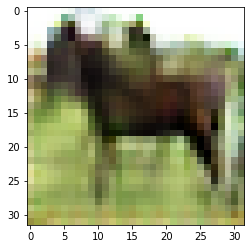

In [19]:
best = g[3]
plt.imshow(torchvision.utils.make_grid(best).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
torchvision.utils.save_image(best, 'best.png')